In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# leer archivo CSV

strava_leyre = pd.read_csv(r"C:\Users\eduar\OneDrive\Escritorio\Master_DataScience_AI\TFM. “Predicción del rendimiento en corredores mediante técnicas de Machine Learning un enfoque aplicado al sector deportivo”\data\activities_leyre_torres.csv")

# mostrar las primeras filas del DataFrame

strava_leyre.head()

,ID de actividad,Fecha de la actividad,Nombre de la actividad,Tipo de actividad,Descripción de la actividad,Tiempo transcurrido,Distancia,Ritmo cardiaco máximo,Esfuerzo Relativo,Desplazamiento,...,Intensidad,Ritmo ajustado en pendientes promedio,Tiempo cronometrado,Ciclos en total,Recuperación,Con mascota,Competición,Carrera de larga distancia,Por una causa,Multimedia
0,11098206131,3 abr. 2024 14:18:21,Carrera de tarde,Carrera,NaN,2064,"6,00",NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11127862006,6 abr. 2024 11:18:49,Carrera de tarde,Carrera,NaN,97994,"4,01",NaN,NaN,False,...,NaN,3.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11149913393,10 abr. 2024 14:11:35,Carrera de tarde,Carrera,NaN,2133,"6,06",NaN,NaN,False,...,NaN,3.133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11197276353,16 abr. 2024 18:19:48,Carrera de noche,Carrera,NaN,1342,"4,02",NaN,NaN,False,...,NaN,3.145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11248002456,23 abr. 2024 17:33:20,Carrera de noche,Carrera,NaN,1378,"4,19",NaN,NaN,False,...,NaN,3.245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
strava_leyre['Distancia'] = strava_leyre['Distancia'].replace(',', '.', regex=True).astype(float)

In [4]:
strava_leyre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 99 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   ID de actividad                                        183 non-null    int64  
 1   Fecha de la actividad                                  183 non-null    object 
 2   Nombre de la actividad                                 183 non-null    object 
 3   Tipo de actividad                                      183 non-null    object 
 4   Descripción de la actividad                            9 non-null      object 
 5   Tiempo transcurrido                                    183 non-null    int64  
 6   Distancia                                              183 non-null    float64
 7   Ritmo cardiaco máximo                                  0 non-null      float64
 8   Esfuerzo Relativo                                 

In [5]:
def limpiar_strava(df):
    # Renombrar columnas para facilitar el manejo
    df = df.rename(columns={
        'Fecha de la actividad': 'activity_date',
        'Tipo de actividad': 'activity_type',
        'Nombre de la actividad': 'activity_name',
        'Distancia': 'distance',
        'Tiempo transcurrido': 'elapsed_time',
        'Velocidad promedio': 'average_speed',
        'Desnivel positivo': 'elevation_gain',
        'Ritmo cardiaco promedio': 'avg_heart_rate',
        'Ritmo cardiaco máximo': 'max_heart_rate',
        'Calorías': 'calories',
        'Cadencia promedio': 'avg_cadence',
        'ID de actividad': 'activity_id',
    })

    # Convertir activity_date a datetime
    df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce')
    df = df[(df['activity_date'].dt.year >= 2024) & (df['activity_type'] == 'Carrera')]

    if df['distance'].max() > 1000:
        df['distance_km'] = df['distance'] / 1000
    else:
        df['distance_km'] = df['distance']

    # Calcular el ritmo promedio en segundos por km
    df['avg_pace_s_per_km'] = df['elapsed_time'] / df['distance_km']

    # Calcular el ritmo en minutos por km
    df['minutes_per_km'] = df['avg_pace_s_per_km'] / 60

    # Función simple para formatear ritmo
    def format_pace(minutes_per_km):
        if pd.isna(minutes_per_km) or minutes_per_km <= 0:
            return "N/A"
        minutes = int(minutes_per_km)
        seconds = int(round((minutes_per_km - minutes) * 60))
        if seconds == 60:
            minutes += 1
            seconds = 0
        return f"{minutes}.{seconds:02d}"

    # Aplicar formato de ritmo
    df['pace_formatted'] = df['minutes_per_km'].apply(format_pace)
    # cambiarla a float
    df['pace_formatted'] = df['pace_formatted'].replace("N/A", np.nan).astype(float)

    # Nueva columna: elapsed_time en formato hh:mm:ss (sin días)
    df['elapsed_time_hms'] = pd.to_timedelta(df['elapsed_time'], unit='s').apply(lambda x: f"{int(x.total_seconds() // 3600):02}:{int((x.total_seconds() % 3600) // 60):02}:{int(x.total_seconds() % 60):02}")

    # Seleccionar solo las columnas relevantes
    columnas = [
        'activity_id', 'activity_date', 'activity_type',
        'distance_km','elapsed_time_hms',
        'pace_formatted','elevation_gain', 'avg_cadence','avg_heart_rate', 'max_heart_rate', 'calories'
    ]
    df = df[columnas]

    return df

strava_limpio = limpiar_strava(strava_leyre)

C:\Users\eduar\AppData\Local\Temp\ipykernel_38112\4120052004.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce')


In [6]:
# añadir columna de usuario

strava_limpio['user'] = 'Leyre'

# borrar pace_formatted > 10

strava_limpio = strava_limpio[strava_limpio['pace_formatted'] <= 10]

In [7]:
# mostrar las ultimas filas del DataFrame limpio

strava_limpio.tail()

,activity_id,activity_date,activity_type,distance_km,elapsed_time_hms,pace_formatted,elevation_gain,avg_cadence,avg_heart_rate,max_heart_rate,calories,user
164,15301748909,2025-07-31 19:17:04,Carrera,7.00,00:32:40,4.40,5.1,NaN,NaN,NaN,NaN,Leyre
178,15674185894,2025-09-02 17:51:41,Carrera,6.01,00:28:07,4.41,9.7,NaN,NaN,NaN,NaN,Leyre
179,15691754048,2025-09-04 07:50:03,Carrera,7.00,00:34:48,4.58,11.1,NaN,NaN,NaN,NaN,Leyre
181,15794552790,2025-09-13 09:22:05,Carrera,5.00,00:24:08,4.50,27.6,NaN,NaN,NaN,NaN,Leyre
182,15812813363,2025-09-14 18:32:48,Carrera,6.00,00:30:47,5.08,8.0,NaN,NaN,NaN,NaN,Leyre


In [8]:
# Guardar el DataFrame limpio en la carpeta csv_clean
strava_limpio.to_csv(r"C:\Users\eduar\OneDrive\Escritorio\Master_DataScience_AI\TFM. “Predicción del rendimiento en corredores mediante técnicas de Machine Learning un enfoque aplicado al sector deportivo”\csv_clean\strava_leyre_torres_limpio.csv", index=False)

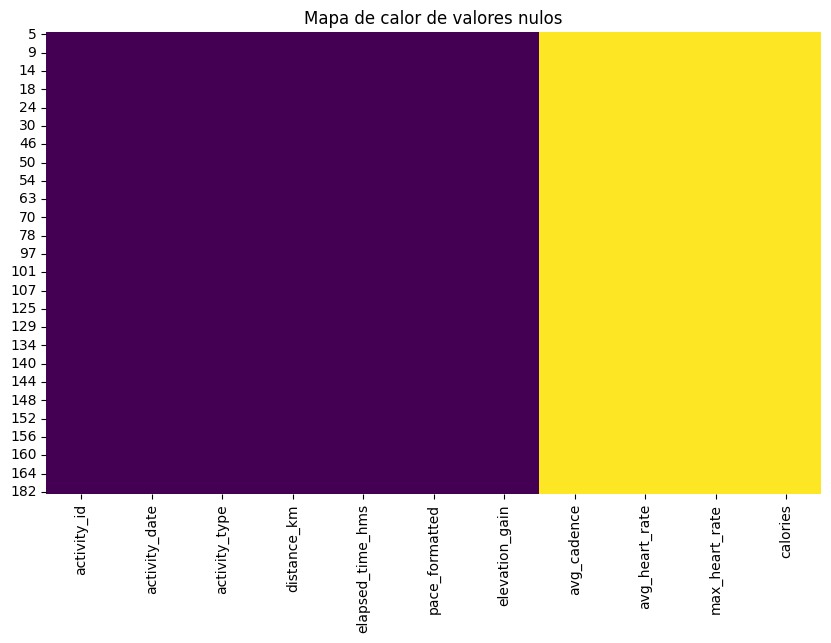

Estadísticos de variables seleccionadas:
       distance_km  pace_formatted  calories
count   101.000000      101.000000       0.0
mean      6.402673        4.906040       NaN
std       1.687663        0.656754       NaN
min       1.980000        4.270000       NaN
25%       5.030000        4.470000       NaN
50%       6.030000        4.580000       NaN
75%       7.000000        5.130000       NaN
max      11.840000        8.130000       NaN


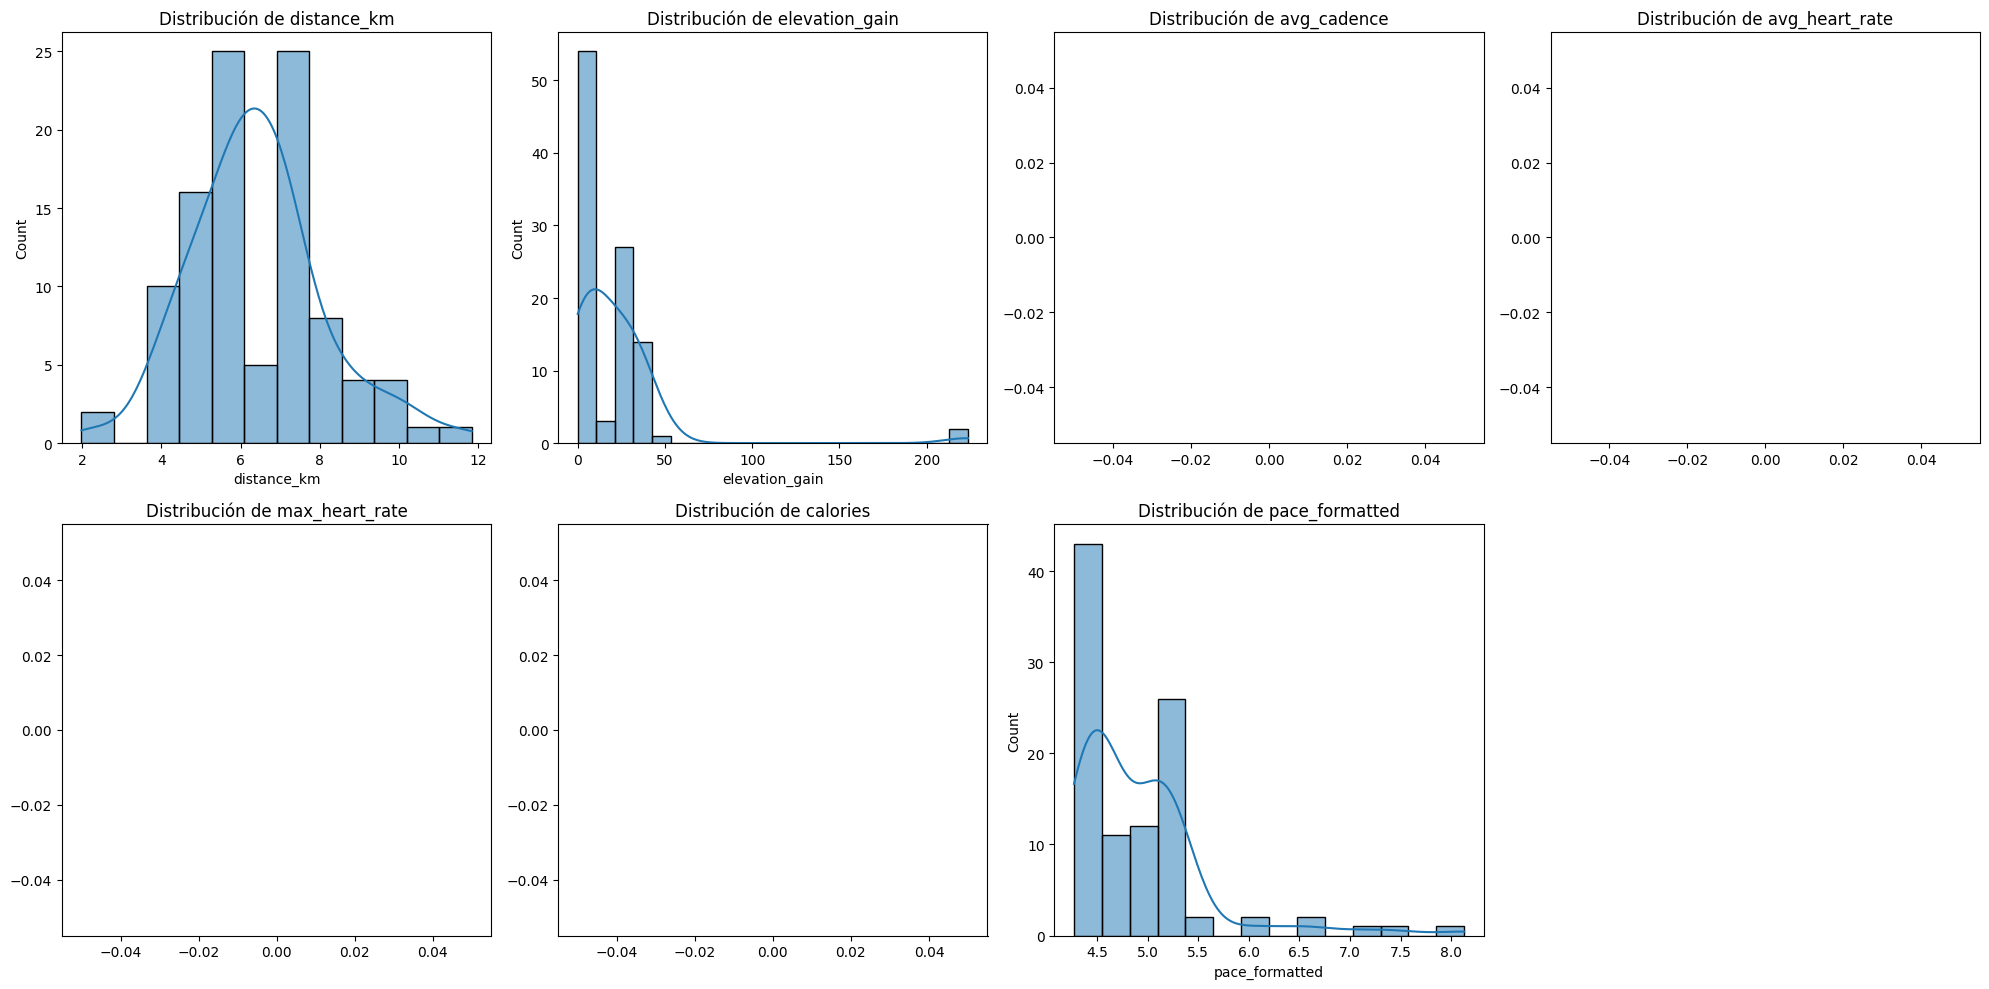

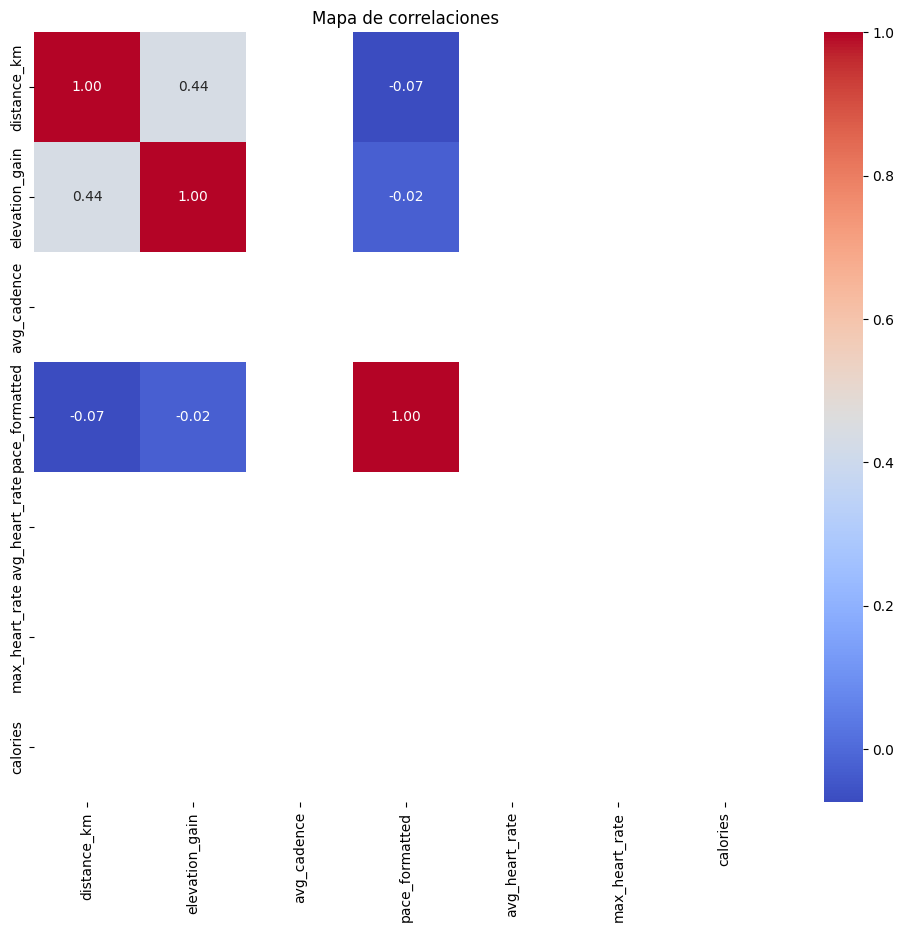

In [9]:
def EDA(data):
    # Seleccionar solo las columnas relevantes
    columnas = [
        'activity_id', 'activity_date', 'activity_type',
        'distance_km', 'elapsed_time_hms',
        'pace_formatted', 'elevation_gain', 'avg_cadence',
        'avg_heart_rate', 'max_heart_rate', 'calories'
    ]
    data = data[columnas]

    # Gráficos para ver nulos
    if data.isnull().sum().sum() == 0:
        print("No hay valores nulos en las variables seleccionadas.")
    else:
        plt.figure(figsize=(10,6))
        sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
        plt.title('Mapa de calor de valores nulos')
        plt.show()

    # Estadísticos de variables seleccionadas
    print("Estadísticos de variables seleccionadas:")
    print(data[['distance_km', 'pace_formatted', 'calories']].describe())

    # Distribución de variables continuas en una sola imagen
    dist_vars = ['distance_km', 'elevation_gain', 'avg_cadence', 'avg_heart_rate', 'max_heart_rate', 'calories', 'pace_formatted']
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    axes = axes.flatten()

    for i, var in enumerate(dist_vars):
        if i < len(axes):
            ax = axes[i]
            if data[var].dtype == 'object':
                data[var].value_counts().plot(kind='bar', ax=ax)
                ax.set_ylabel('Frecuencia')
            else:
                sns.histplot(data[var].dropna(), kde=True, ax=ax)
            ax.set_title(f'Distribución de {var}')

    # Eliminar el subplot vacío si hay menos variables que subplots
    for j in range(len(dist_vars), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Mapa de correlaciones (todas las variables numéricas relevantes)
    plt.figure(figsize=(12,10))
    corr_vars = ['distance_km', 'elevation_gain', 'avg_cadence','pace_formatted', 'avg_heart_rate', 'max_heart_rate', 'calories']
    corr = data[corr_vars].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Mapa de correlaciones')
    plt.show()

EDA(strava_limpio)